# Setting up the notebook and realtive paths

In [2]:
# Discover repo root and read all CSV files from the per-series folders
from pathlib import Path
import pandas as pd

# Find repo root (stop at folder containing pyproject.toml or .git)
repo_root = Path.cwd()
for candidate in [repo_root] + list(repo_root.parents):
    if (candidate / 'pyproject.toml').exists() or (candidate / '.git').exists():
        repo_root = candidate
        break
print('Repo root:', repo_root)

wiertsema_dir = repo_root / 'output_data' / 'only_csv_wiertsema'
fugro_dir = repo_root / 'output_data' / 'only_csv_fugro'
# Directory containing meteorological/stressor CSVs
stressor_dir = repo_root / 'input_stressors'
# Explicit stressor file paths used elsewhere in notebooks
precip_path = stressor_dir / 'Neerslag_2021_2025.csv'
evap_path = stressor_dir / 'Verdamping_2021_2025.csv'

out_fig = repo_root / 'output_data' / 'figures'
out_fig.mkdir(parents=True, exist_ok=True)

print('wiertsema_dir ->', wiertsema_dir)
print('fugro_dir    ->', fugro_dir)
print('precip_path ->', precip_path)
print('evap_path  ->', evap_path)

Repo root: d:\Users\jvanruitenbeek\data_validation
wiertsema_dir -> d:\Users\jvanruitenbeek\data_validation\output_data\only_csv_wiertsema
fugro_dir    -> d:\Users\jvanruitenbeek\data_validation\output_data\only_csv_fugro
precip_path -> d:\Users\jvanruitenbeek\data_validation\input_stressors\Neerslag_2021_2025.csv
evap_path  -> d:\Users\jvanruitenbeek\data_validation\input_stressors\Verdamping_2021_2025.csv


# Loading in the precipitation and evap file

Based on data with the "." seperator

For different dataset based on hourly data with the ";" and "," seperators

In [3]:
df_prec = (
    pd.read_csv(
        precip_path,
        sep=";",              # <-- semicolon-delimited file
        decimal=",",          # <-- comma decimals (e.g., 0,05)
        index_col=0,
        parse_dates=[0],      # parse the first column as datetime
        dayfirst=True,        # because '1-01-21 0:00' is D-M-YY
        # date_format="%d-%m-%y %H:%M",  # (optional) faster & stricter
        encoding="utf-8-sig",
        encoding_errors="replace",
    )
    if precip_path.exists() else None
)

df_prec_mm = df_prec / 10

df_evap = (
    pd.read_csv(
        evap_path,
        sep=";",              # <-- semicolon-delimited file
        decimal=",",          # <-- comma decimals (e.g., 0,05)
        index_col=0,
        parse_dates=[0],      # parse the first column as datetime
        dayfirst=True,        # because '1-01-21 0:00' is D-M-YY
        # date_format="%d-%m-%y %H:%M",  # (optional) faster & stricter
        encoding="utf-8-sig",
        encoding_errors="replace",
    )
    if precip_path.exists() else None
)

C:\Users\jvanruitenbeek\AppData\Local\Temp\109\ipykernel_56532\3403301890.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(


<Axes: xlabel='timestamp'>

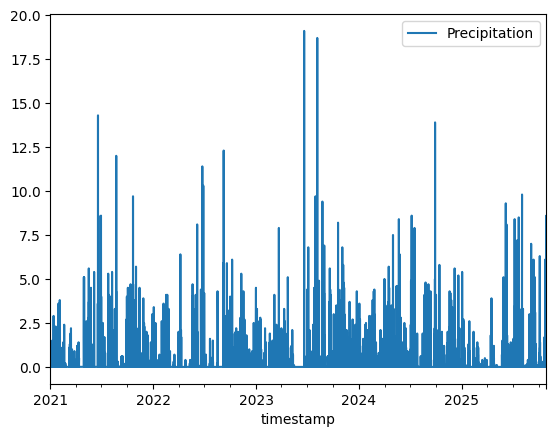

In [4]:
# Bestand is van het KNMI, neerslag in 0.1 mm dus omzetten naar mm
df_prec_mm = df_prec / 10
df_prec_mm.plot()

# Function to create the .csv files

In [9]:
from pathlib import Path
import pandas as pd

def process_measurement_csv(
    filepath: Path,
    df_prec_mm: pd.DataFrame,
    df_evap: pd.DataFrame,
    output_dir: Path,
    output_suffix="_processed.csv"
):
    """
    Processes a groundwater head CSV file: aligns with precipitation and evapotranspiration,
    calculates recharge and head change (head_t1), and writes selected columns to a new CSV.

    Parameters:
        filepath (Path): Path to the input CSV.
        df_prec_mm (pd.DataFrame): Precipitation data (with datetime index).
        df_evap (pd.DataFrame): Evapotranspiration data (with datetime index).
        output_dir (Path): Directory to save processed CSVs.
        output_suffix (str): Suffix added to the output filename.
    """
    try:
        # Load and parse input CSV
        head_df = pd.read_csv(
            filepath,
            index_col=0,
            parse_dates=True,
            encoding="utf-8-sig",
            encoding_errors="replace"
        )

        # Drop duplicate timestamps, keeping the last
        head_df = head_df[~head_df.index.duplicated(keep="last")]

        # Ensure all values are numeric
        head_df = head_df.apply(pd.to_numeric, errors="coerce")

        # Align to reference index
        ref_index = df_evap.index
        head_df = head_df.reindex(ref_index)

        # Merge with precipitation and evapotranspiration
        merged = pd.concat([
            df_prec_mm.reindex(ref_index),
            df_evap.reindex(ref_index),
            head_df
        ], axis=1)

        # Rename the head column (3rd column) to "head"
        if merged.shape[1] > 2:
            merged = merged.rename(columns={merged.columns[2]: "head"})

        # Ensure required columns exist and are numeric
        for col in ["Precipitation", "Evapotranspiration", "head"]:
            if col in merged.columns:
                merged[col] = pd.to_numeric(merged[col], errors="coerce")
            else:
                raise ValueError(f"Missing column: {col}")

        # Compute recharge and head_t1
        merged["recharge"] = merged["Precipitation"] - merged["Evapotranspiration"]
        merged["head_t1"] = merged["head"].diff()

        # Select and reorder columns
        output_df = merged[["head", "Precipitation", "Evapotranspiration", "recharge", "head_t1"]]

        # Drop rows with NaNs in all selected columns
        output_df = output_df.dropna(how="all")

        # Ensure output directory exists
        output_dir.mkdir(parents=True, exist_ok=True)

        # Write to CSV
        output_file = output_dir / f"{filepath.stem}{output_suffix}"
        output_df.index.name = "timestamp"
        output_df.to_csv(output_file, encoding="utf-8-sig")

        print(f"✓ Processed: {filepath.name} → {output_file.name}")
        return output_file

    except Exception as e:
        print(f"✗ Error processing {filepath.name}: {e}")
        return None

# Use the function

In [11]:
# Set directories
input_dir = repo_root / "output_data" / "only_csv_wiertsema"
output_dir = repo_root / "output_data" / "hourly_csv_wiertsema_knmi"

# Get all CSV files
csv_files = sorted(input_dir.glob("*.csv"))
print(f"Found {len(csv_files)} CSV files in {input_dir.name}")

# Process each file
for i, file_path in enumerate(csv_files, start=1):
    print(f"[{i}/{len(csv_files)}] Processing: {file_path.name}")
    process_measurement_csv(
        filepath=file_path,
        df_prec_mm=df_prec_mm,
        df_evap=df_evap,
        output_dir=output_dir
    )

print(f"\n✓ All processed CSVs saved to: {output_dir}")

Found 241 CSV files in only_csv_wiertsema
[1/241] Processing: 83034-1 HB003PB01 BE0049+00_INST_B_GMW_PB1_F-365.csv
✓ Processed: 83034-1 HB003PB01 BE0049+00_INST_B_GMW_PB1_F-365.csv → 83034-1 HB003PB01 BE0049+00_INST_B_GMW_PB1_F-365_processed.csv
[2/241] Processing: 83034-1 HB015PB01 BE0341+40_INST_B_GMW_PB1_F-599.csv
✓ Processed: 83034-1 HB015PB01 BE0341+40_INST_B_GMW_PB1_F-599.csv → 83034-1 HB015PB01 BE0341+40_INST_B_GMW_PB1_F-599_processed.csv
[3/241] Processing: 83034-1 HB016PB01 BE0341+40_BIT_GMW_PB1_F-616.csv
✓ Processed: 83034-1 HB016PB01 BE0341+40_BIT_GMW_PB1_F-616.csv → 83034-1 HB016PB01 BE0341+40_BIT_GMW_PB1_F-616_processed.csv
[4/241] Processing: 86349-1 HB002PB01 HB_BE0072+3_BIKR_GMW_PB1_F-246.csv
✓ Processed: 86349-1 HB002PB01 HB_BE0072+3_BIKR_GMW_PB1_F-246.csv → 86349-1 HB002PB01 HB_BE0072+3_BIKR_GMW_PB1_F-246_processed.csv
[5/241] Processing: 86349-1 HB007PB01 HB_BE0092+15_BIB_GMW_PB1_F-450.csv
✓ Processed: 86349-1 HB007PB01 HB_BE0092+15_BIB_GMW_PB1_F-450.csv → 86349-1 HB